# Continuous Control

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the second project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.insert(1, 'scripts/')  # TODO: insert at 1, 0 is the script path (or '' in REPL)

from unityagents import UnityEnvironment
import numpy as np
import torch
from collections import deque
import shutil
import os
import pprint 
import matplotlib.pyplot as plt
%matplotlib inline

from ppo_agent import PPO_Agent
from params import Params
from logger import Logger
from CustomSummaryWriter import CustomSummaryWriter

In [3]:
# Time related Utilities
from datetime import datetime
import pytz

def get_time(format):
    utc_now = pytz.utc.localize(datetime.utcnow())
    pst_now = utc_now.astimezone(pytz.timezone("Asia/Singapore"))   # Set to your own timezone: pytz.all_timezones
    return pst_now.strftime(format)

def total_train_duration(start_time, end_time):
    duration = end_time - start_time              # For build-in functions
    duration_in_s = duration.total_seconds()      # Total number of seconds between dates
    days    = divmod(duration_in_s, 86400)        # Get days (without [0]!)
    hours   = divmod(days[1], 3600)               # Use remainder of days to calc hours
    minutes = divmod(hours[1], 60)                # Use remainder of hours to calc minutes
    seconds = divmod(minutes[1], 1)               # Use remainder of minutes to calc seconds
    print("TOTAL TRAINING DURATION: %d days, %d hours, %d minutes and %d seconds" % (days[0], hours[0], minutes[0], seconds[0]))

In [4]:
# WARN: SLOWS DOWN TRAINING ALOT..
# torch.autograd.set_detect_anomaly(True)
# np.seterr(all='raise')

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Reacher.app"`
- **Windows** (x86): `"path/to/Reacher_Windows_x86/Reacher.exe"`
- **Windows** (x86_64): `"path/to/Reacher_Windows_x86_64/Reacher.exe"`
- **Linux** (x86): `"path/to/Reacher_Linux/Reacher.x86"`
- **Linux** (x86_64): `"path/to/Reacher_Linux/Reacher.x86_64"`
- **Linux** (x86, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86"`
- **Linux** (x86_64, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86_64"`

For instance, if you are using a Mac, then you downloaded `Reacher.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Reacher.app")
```

In [4]:
env = UnityEnvironment(file_name='Crawler_Windows_x86_64/Crawler.exe', worker_id=101)
# env = UnityEnvironment(file_name='Crawler_Windows_x86_64/Crawler.exe', no_graphics=True)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: CrawlerBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 129
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 20
        Vector Action descriptions: , , , , , , , , , , , , , , , , , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [5]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, a double-jointed arm can move to target locations. A reward of `+0.1` is provided for each step that the agent's hand is in the goal location. Thus, the goal of your agent is to maintain its position at the target location for as many time steps as possible.

The observation space consists of `33` variables corresponding to position, rotation, velocity, and angular velocities of the arm.  Each action is a vector with four numbers, corresponding to torque applicable to two joints.  Every entry in the action vector must be a number between `-1` and `1`.

Run the code cell below to print some information about the environment.

In [6]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 12
Size of each action: 20
There are 12 agents. Each observes a state with length: 129
The state for the first agent looks like: [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  2.25000000e+00
  1.00000000e+00  0.00000000e+00  1.78813934e-07  0.00000000e+00
  1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  6.06093168e-01 -1.42857209e-01 -6.06078804e-01  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  1.33339906e+00 -1.42857209e-01
 -1.33341408e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -6.0609

### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Once this cell is executed, you will watch the agent's performance, if it selects an action at random with each time step.  A window should pop up that allows you to observe the agent, as it moves through the environment.  

Of course, as part of the project, you'll have to change the code so that the agent is able to use its experience to gradually choose better actions when interacting with the environment!

In [8]:
# env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
# states = env_info.vector_observations                  # get the current state (for each agent)
# scores = np.zeros(num_agents)                          # initialize the score (for each agent)

# while True:
#     actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
#     actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
#     env_info = env.step(actions)[brain_name]           # send all actions to tne environment
#     next_states = env_info.vector_observations         # get next state (for each agent)
#     rewards = env_info.rewards                         # get reward (for each agent)
#     dones = env_info.local_done                        # see if episode finished
#     scores += env_info.rewards                         # update the score (for each agent)
#     states = next_states                               # roll over states to next time step
#     if np.any(dones):                                  # exit loop if episode finished
#         break
# print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

When finished, you can close the environment.

In [9]:
# env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

While training is taking place, statistics on agent performance are available from Tensorboard. To launch it use:
```python
cd <PROJECT_DIR>
tensorboard --logdir=runs
```

In [29]:
def ppo(params=Params(), logger=Logger()):

    print ("***STARTED TRAINING AT {} \n".format(get_time('%Y-%m-%d--%H:%M:%S')))
    start_time  = datetime.now() 
    env_info = env.reset(train_mode=True)[brain_name]
    action_size = brain.vector_action_space_size
    state_size = env_info.vector_observations.shape[1]
    logger.initialize(agent, state_size, action_size)
    
#     try:
    start_eps = params.eps_to_resume_from if not params.restart_training else 1        
    for i_episode in range(start_eps, params.n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]  # reset the environment
        states = env_info.vector_observations              # get the current state
        score = np.zeros(len(env_info.agents))
        hasNaN = False

        for t in range(params.max_t):                             

            # REPORT NAN STATES
            if np.isnan(states).any():
                print('\nNaN found in states. Skipping this episode.')
                hasNaN = True
                break

            # Perform actions from each agent's policy network (clipped actions [0, -1])  
            actions, log_probs, _, values = agent.act(states, agent.std_scale)
            env_info = env.step(actions)[brain_name]      
            next_states, rewards, dones = env_info.vector_observations, env_info.rewards, env_info.local_done

            # REPORT NAN ACTIONS
            if np.isnan(next_states).any():
                print("NaN next_states Found! Skipping this episode.")
                hasNaN = True
                break
                
            if np.isnan(actions).any():
                print('NaN found in actions. Skipping this episode.')
                hasNaN = True
                break

            if np.isnan(rewards).any():
                print("NaN Reward Found! Skipping this episode.")
                hasNaN = True
                break

            # Only collect and learn from subset of data from episode (representative enough)
            if t < params.num_steps_collect_data:
                agent.step(states, actions, rewards, log_probs, values, dones)
                last_states = next_states
                
            # Allow crawler to keep resetting if fall (score -> 0)
            # Continue to accumulate score over entire duration max_t to maxmimize observable score
            states = next_states
            score += np.array(rewards)             
            for i in range(len(dones)):
                if dones[i]:
                    logger.log_score(score[i])
                    score[i] = 0
            
            # Break if all agents are done (auto @ step=1000)
            if all(dones):   # any()
                break 
            
        if not hasNaN:
            # Learn from episode (add last state if using GAE)
            agent.add_last_state(last_states)
            agent.learn()

            # Print crucial results for progress tracking
            logger.log_stats(i_episode, agent.actor_loss, agent.critic_loss, agent.entropy_loss)
            print('\rEpisode {}\t Score [This Eps]: {:.2f} \t Steps: {}'.format(i_episode, logger.scores_list[-1], t), end="")

            if i_episode % params.save_every == 0:
                logger.save_weights(i_episode)

            if i_episode % params.print_every == 0:
                print('\rEpisode {}: \tActor Loss: {:.2f} \tCritic Loss: {:.2f} \n\t\tAvg Score [100eps]: {:.2f} \t Steps: {}\n'
                      .format(i_episode, np.mean(logger.actor_loss_deque), np.mean(logger.critic_loss_deque), np.mean(logger.scores_deque), t))

                if np.mean(logger.scores_deque) >= params.target_score:
                    print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'
                          .format(i_episode, np.mean(logger.scores_deque)))
                    if params.terminate_on_target_score:
                        break

    # Plot graphs & save final weights
    logger.save_weights(i_episode)
    if params.plot_stats:
        logger.plot_stats()
    logger.log_overall_perf_tb()
    total_train_duration(start_time=start_time, end_time=datetime.now())
    print ("***TRAINING STOPPED AT {} ".format(get_time('%Y-%m-%d--%H:%M:%S')))

#     # Catch any exceptions (Esp with keyboard interrupts)
#     except BaseException as error:
#         print('\n\n==== An exception occurred: {}'.format(error))
#         #logger.print_weights()
#         logger.save_weights(i_episode)
#         if params.plot_stats:
#             logger.plot_stats()
#         logger.log_overall_perf_tb()
#         total_train_duration(start_time=start_time, end_time=datetime.now())
#         print ("***TRAINING STOPPED AT {} ".format(get_time('%Y-%m-%d--%H:%M:%S')))
    
    return logger.scores_list


============  HYPERPARAMS ============
DEVICE:  cuda:0
RANDOM SEED:  1
BATCH_SIZE:  1024
HIDDEN_SIZES (ACTOR):  (1024, 1024, 512)
HIDDEN_SIZES (CRITIC):  (1024, 1024, 512)
GAMMA:  0.95
LR (Joint):  0.0001
LR_DECAY:  0.995
LR_MIN:  1e-05
BETA:  0.01
BETA_DECAY:  0.9975
BETA_MIN:  0.0
EPS:  0.1
EPS_DECAY:  0.995
EPS_MIN:  0.0
WEIGHT_DECAY:  0.0001
USE GAE:  True
GAE TAU:  0.99
GRAD_CLIP:  1.0




============  HYPERPARAMS ============
DEVICE:  cuda:0
RANDOM SEED:  0
BATCH_SIZE:  1024
HIDDEN_SIZES (ACTOR):  (1024, 1024, 512)
HIDDEN_SIZES (CRITIC):  (1024, 1024, 512)
GAMMA:  0.95
LR (Joint):  0.0001
LR_DECAY:  0.995
LR_MIN:  1e-05
BETA:  0.01
BETA_DECAY:  0.9975
BETA_MIN:  0.0
EPS:  0.1
EPS_DECAY:  0.995
EPS_MIN:  0.0
WEIGHT_DECAY:  0.0001
USE GAE:  True
GAE TAU:  0.99
GRAD_CLIP:  1.0

***STARTED TRAINING AT 2022-05-03--13:59:41 

9.95e-05
Episode 1	 Score [This Eps]: 0.96 	 Steps: 20

scripts\logger.py:63: RuntimeWarning: Mean of empty slice
  self.critic_loss_list.append(critic_loss)
scripts\logger.py:69: RuntimeWarning: Mean of empty slice
  self.tb.add_scalar(f"{self.agent_ns}/Critic Loss", critic_loss, episode)


9.90025e-05
Episode 2: 	Actor Loss: 0.08 	Critic Loss: 0.12 
		Running Avg Score [100eps]: nan 	 Steps: 20

9.85074875e-05
Episode 3	 Score [This Eps]: 1.03 	 Steps: 209.80149500625e-05
Episode 4: 	Actor Loss: 0.09 	Critic Loss: 0.13 
		Running Avg Score [100eps]: nan 	 Steps: 20

9.75248753121875e-05
Episode 5	 Score [This Eps]: 1.00 	 Steps: 209.703725093562657e-05
Episode 6: 	Actor Loss: 0.10 	Critic Loss: 0.12 
		Running Avg Score [100eps]: nan 	 Steps: 20

9.655206468094843e-05
Episode 7	 Score [This Eps]: 0.88 	 Steps: 209.606930435754369e-05
Episode 8: 	Actor Loss: 0.12 	Critic Loss: 0.11 
		Running Avg Score [100eps]: nan 	 Steps: 20

9.558895783575598e-05
Episode 9	 Score [This Eps]: 0.81 	 Steps: 209.51110130465772e-05
Episode 10: 	Actor Loss: 0.12 	Critic Loss: 0.10 
		Running Avg Score [100eps]: nan 	 Steps: 20

=====  =====


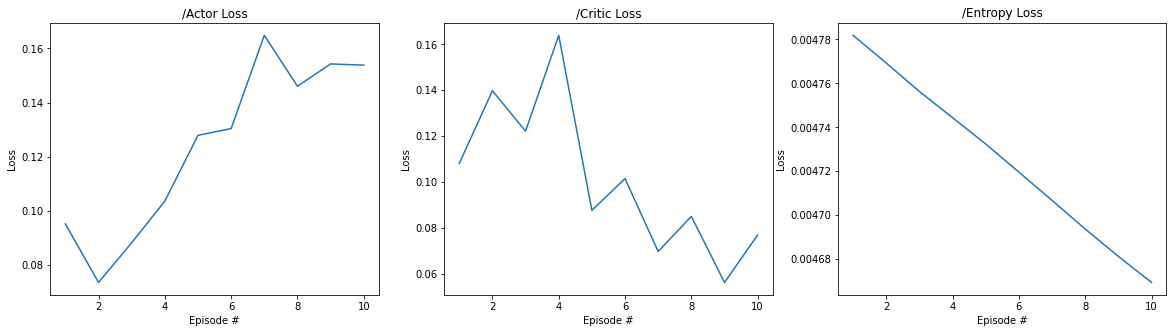

TOTAL TRAINING DURATION: 0 days, 0 hours, 0 minutes and 1 seconds
***TRAINING STOPPED AT 2022-05-03--13:59:43 


C:\Users\derek\anaconda3\envs\drlnd_gpu\lib\site-packages\numpy\core\fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\derek\anaconda3\envs\drlnd_gpu\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]

In [64]:
##################
# QUICK TEST
##################

# Params Override: Initialized in params.py
params = Params()
params.verbose = True
params.random_seed = 0
params.n_episodes=10
params.max_t = 20
params.print_every = 2
params.save_every = 2
params.log_weights_every = 100
params.terminate_on_target_score = False
params.plot_stats = True
params.lr = 1e-4                  
params.checkpoint_actor_weights_dir = 'weights/checkpoint_actor/test'
params.checkpoint_critic_weights_dir = 'weights/checkpoint_critic/test'


#### MAIN #####
logger = Logger(params)
agent = PPO_Agent(state_size, action_size, params=params)
ppo(params, logger)

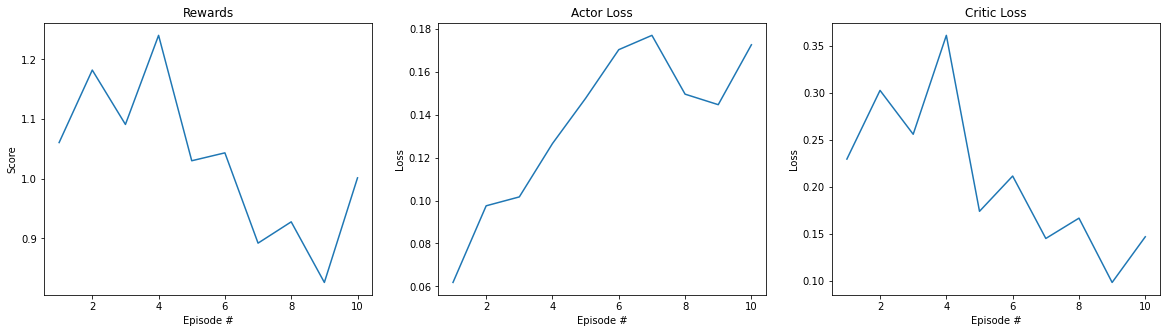

In [26]:
def plot_graph(logger):
    
    score_arr  = np.array(logger.scores_list)
    score_arr[score_arr < 0] = 0
    _, axs = plt.subplots(1, 3, figsize=(20, 5))

    # Scores
    axs[0].plot(np.arange(1, len(logger.scores_list)+1), score_arr)
    axs[0].set(xlabel='Episode #', ylabel='Score')
    axs[0].set_title('Rewards')
        
    # Actor Loss
    axs[1].plot(np.arange(1, len(logger.actor_loss_list)+1), logger.actor_loss_list)
    axs[1].set(xlabel='Episode #', ylabel='Loss')
    axs[1].set_title('Actor Loss')
    
    # Critic Loss
    axs[2].plot(np.arange(1, len(logger.critic_loss_list)+1), logger.critic_loss_list)
    axs[2].set(xlabel='Episode #', ylabel='Loss')
    axs[2].set_title('Critic Loss')
    plt.show()
    
plot_graph(logger)

In [ ]:
##################
# LONGER TEST
# NOTE: ACTUALLY DECAYING STD_SCALE PARAM
##################

# Params Override: Initialized in params.py
params = Params()
params.verbose = True
params.random_seed = 0
params.n_episodes=10000
params.max_t = 900       # Max steps per eps = 1000
params.print_every = 10
params.save_every = 20
params.log_weights_every = 100
params.terminate_on_target_score = False
params.plot_stats = True
params.lr = 1e-4                  
params.checkpoint_actor_weights_dir = 'weights/checkpoint_actor/test'
params.checkpoint_critic_weights_dir = 'weights/checkpoint_critic/test'


#### MAIN #####
tb=CustomSummaryWriter()
logger = Logger(params, tb=tb)
agent = PPO_Agent(state_size, action_size, params=params)
ppo(params, logger)


============  HYPERPARAMS ============
DEVICE:  cuda:0
RANDOM SEED:  0
BATCH_SIZE:  1024
HIDDEN_SIZES (ACTOR):  (1024, 1024, 512)
HIDDEN_SIZES (CRITIC):  (1024, 1024, 512)
LR (Joint):  0.0001
GAMMA:  0.95
BETA:  0.01
BETA_DECAY:  0.9975
BETA_MIN:  0.0
EPS:  0.1
EPS_DECAY:  0.995
EPS_MIN:  0.0
WEIGHT_DECAY:  0.0001
USE GAE:  True
GAE TAU:  0.99
GRAD_CLIP:  1.0

***STARTED TRAINING AT 2022-04-17--19:14:46 

Episode 10: 	Actor Loss: 0.06 	Critic Loss: 0.69 
		Average Score: 45.22

Episode 20: 	Actor Loss: 0.04 	Critic Loss: 0.82 
		Average Score: 56.29

Episode 30: 	Actor Loss: 0.31 	Critic Loss: 3.38 
		Average Score: 117.90

Episode 40: 	Actor Loss: 0.30 	Critic Loss: 15.91 
		Average Score: 285.59

Episode 50: 	Actor Loss: 0.27 	Critic Loss: 25.89 
		Average Score: 368.85

Episode 60: 	Actor Loss: 0.48 	Critic Loss: 40.11 
		Average Score: 421.72

Episode 70: 	Actor Loss: 0.36 	Critic Loss: 29.64 
		Average Score: 400.96

Episode 80: 	Actor Loss: 0.24 	Critic Loss: 19.94 
		Average Sc

Episode 1040: 	Actor Loss: 0.35 	Critic Loss: 0.49 
		Average Score: 32.58

Episode 1050: 	Actor Loss: 0.36 	Critic Loss: 0.18 
		Average Score: 43.62

Episode 1060: 	Actor Loss: 0.35 	Critic Loss: 0.20 
		Average Score: 40.55

Episode 1070: 	Actor Loss: 0.38 	Critic Loss: 0.34 
		Average Score: 40.63

Episode 1080: 	Actor Loss: 0.36 	Critic Loss: 0.27 
		Average Score: 40.64

Episode 1090: 	Actor Loss: 0.35 	Critic Loss: 0.19 
		Average Score: 41.19

Episode 1100: 	Actor Loss: 0.38 	Critic Loss: 0.19 
		Average Score: 40.19

Episode 1110: 	Actor Loss: 0.37 	Critic Loss: 0.35 
		Average Score: 36.64

Episode 1120: 	Actor Loss: 0.39 	Critic Loss: 0.61 
		Average Score: 38.70

Episode 1130: 	Actor Loss: 0.33 	Critic Loss: 0.28 
		Average Score: 38.36

Episode 1140: 	Actor Loss: 0.33 	Critic Loss: 0.17 
		Average Score: 38.94

Episode 1150: 	Actor Loss: 0.33 	Critic Loss: 0.23 
		Average Score: 38.10

Episode 1160: 	Actor Loss: 0.34 	Critic Loss: 0.27 
		Average Score: 40.17

Episode 1170


============  HYPERPARAMS ============
DEVICE:  cuda:0
RANDOM SEED:  0
BATCH_SIZE:  1024
HIDDEN_SIZES (ACTOR):  (1024, 1024, 512)
HIDDEN_SIZES (CRITIC):  (1024, 1024, 512)
LR (Joint):  0.0001
GAMMA:  0.95
BETA:  0.01
BETA_DECAY:  0.9975
BETA_MIN:  0.0
EPS:  0.1
EPS_DECAY:  0.995
EPS_MIN:  0.0
WEIGHT_DECAY:  0.0001
USE GAE:  True
GAE TAU:  0.99
GRAD_CLIP:  1.0

***STARTED TRAINING AT 2022-05-03--01:02:31 

Episode 10: 	Actor Loss: 0.06 	Critic Loss: 0.71 
		Average Score: 50.88 	 Steps: 1002

Episode 20: 	Actor Loss: 0.04 	Critic Loss: 0.80 
		Average Score: 63.09 	 Steps: 1002

Episode 30: 	Actor Loss: 0.11 	Critic Loss: 1.64 
		Average Score: 104.85 	 Steps: 1002

Episode 40: 	Actor Loss: 0.34 	Critic Loss: 1.93 
		Average Score: 1107.62 	 Steps: 10000

Episode 45	 Score: 2148.18 	 Steps: 10000

==== An exception occurred: 
=====  =====


KeyboardInterrupt: 

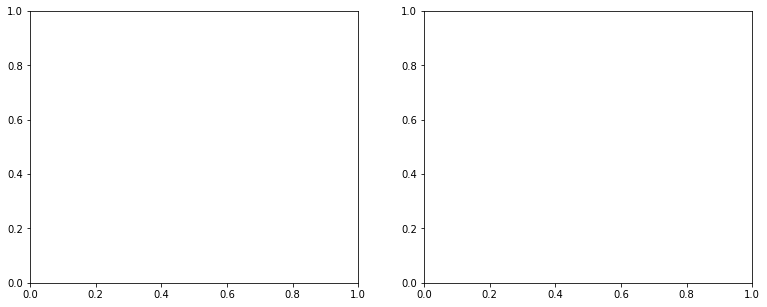

In [34]:
##################
# LONGER TEST
# NOTE: ACTUALLY DECAYING STD_SCALE PARAM
# TEST: DON'T RESET SCORES WHEN AGENT IS 'DONE'
##################

# Params Override: Initialized in params.py
params = Params()
params.verbose = True
params.random_seed = 0
params.n_episodes=10000
params.max_t = 10000       # Max steps per eps = 1000
params.print_every = 10
params.save_every = 20
params.log_weights_every = 100
params.terminate_on_target_score = False
params.plot_stats = True
params.lr = 1e-4                  
params.checkpoint_actor_weights_dir = 'weights/checkpoint_actor/test'
params.checkpoint_critic_weights_dir = 'weights/checkpoint_critic/test'


#### MAIN #####
tb=CustomSummaryWriter()
logger = Logger(params, tb=tb)
agent = PPO_Agent(state_size, action_size, params=params)
ppo(params, logger)

In [60]:
##################
# LONGER TEST
# NOTE: ACTUALLY DECAYING STD_SCALE PARAM
# TEST: Retain score of agent from start till it falls. Avg score accumulated in deque is taken.
##################

# Params Override: Initialized in params.py
params = Params()
params.verbose = True
params.random_seed = 0
params.n_episodes=10000
params.max_t = 10000       # Max steps per eps = 1000
params.print_every = 10
params.save_every = 20
params.log_weights_every = 100
params.terminate_on_target_score = False
params.plot_stats = True
params.lr = 1e-4                  
params.checkpoint_actor_weights_dir = 'weights/checkpoint_actor/test'
params.checkpoint_critic_weights_dir = 'weights/checkpoint_critic/test'


#### MAIN #####
tb=CustomSummaryWriter()
logger = Logger(params, tb=tb)
agent = PPO_Agent(state_size, action_size, params=params)
ppo(params, logger)


============  HYPERPARAMS ============
DEVICE:  cuda:0
RANDOM SEED:  0
BATCH_SIZE:  1024
HIDDEN_SIZES (ACTOR):  (1024, 1024, 512)
HIDDEN_SIZES (CRITIC):  (1024, 1024, 512)
LR (Joint):  0.0001
GAMMA:  0.95
BETA:  0.01
BETA_DECAY:  0.9975
BETA_MIN:  0.0
EPS:  0.1
EPS_DECAY:  0.995
EPS_MIN:  0.0
WEIGHT_DECAY:  0.0001
USE GAE:  True
GAE TAU:  0.99
GRAD_CLIP:  1.0

***STARTED TRAINING AT 2022-05-03--11:35:38 

Episode 10: 	Actor Loss: 0.06 	Critic Loss: 0.33 teps: 1003
		Running Avg Score [100eps]: 49.61 	 Steps: 1003

Episode 20: 	Actor Loss: 0.05 	Critic Loss: 0.34 teps: 1003
		Running Avg Score [100eps]: 59.53 	 Steps: 1003

Episode 30: 	Actor Loss: 0.09 	Critic Loss: 0.50 teps: 100000
		Running Avg Score [100eps]: 56.11 	 Steps: 10000

Episode 40: 	Actor Loss: 0.21 	Critic Loss: 1.15 Steps: 1003
		Running Avg Score [100eps]: 140.65 	 Steps: 1003

Episode 50: 	Actor Loss: 0.23 	Critic Loss: 3.21 Steps: 10030
		Running Avg Score [100eps]: 371.18 	 Steps: 1003

Episode 60: 	Actor Loss: 0.

KeyboardInterrupt: 

In [30]:
##################
# LONGER TEST
# NOTE: ACTUALLY DECAYING STD_SCALE PARAM
# TEST: Retain score of agent from start till it falls. Avg score accumulated in deque is taken.
# DEcaying LR
##################

# Params Override: Initialized in params.py
params = Params()
params.verbose = True
params.random_seed = 0
params.n_episodes=10000
params.max_t = 10000       # Max steps per eps = 1000
params.print_every = 10
params.save_every = 20
params.log_weights_every = 100
params.terminate_on_target_score = False
params.plot_stats = True
params.lr = 1e-4                  
params.checkpoint_actor_weights_dir = 'weights/checkpoint_actor/test'
params.checkpoint_critic_weights_dir = 'weights/checkpoint_critic/test'


#### MAIN #####
tb=CustomSummaryWriter()
logger = Logger(params, tb=tb)
agent = PPO_Agent(state_size, action_size, params=params)
ppo(params, logger)


============  HYPERPARAMS ============
DEVICE:  cuda:0
RANDOM SEED:  0
BATCH_SIZE:  1024
HIDDEN_SIZES (ACTOR):  (1024, 1024, 512)
HIDDEN_SIZES (CRITIC):  (1024, 1024, 512)
GAMMA:  0.95
LR (Joint):  0.0001
LR_DECAY:  0.995
LR_MIN:  1e-05
BETA:  0.01
BETA_DECAY:  0.9975
BETA_MIN:  0.0
EPS:  0.1
EPS_DECAY:  0.995
EPS_MIN:  0.0
WEIGHT_DECAY:  0.0001
USE GAE:  True
GAE TAU:  0.99
GRAD_CLIP:  1.0

***STARTED TRAINING AT 2022-05-03--14:28:04 

Episode 10: 	Actor Loss: 0.06 	Critic Loss: 0.33 
		Avg Score [100eps]: 49.97 	 Steps: 1002

Episode 20: 	Actor Loss: 0.05 	Critic Loss: 0.34 
		Avg Score [100eps]: 57.54 	 Steps: 1002

Episode 30: 	Actor Loss: 0.09 	Critic Loss: 0.46 9
		Avg Score [100eps]: 104.41 	 Steps: 9999

Episode 40: 	Actor Loss: 0.14 	Critic Loss: 0.70 2
		Avg Score [100eps]: 67.98 	 Steps: 1002

Episode 44	 Score [This Eps]: 144.32 	 Steps: 9999NaN next_states Found! Skipping this episode.

NaN found in states. Skipping this episode.

NaN found in states. Skipping this episod

KeyboardInterrupt: 

In [33]:
##################
# LONGER TEST
# NOTE: ACTUALLY DECAYING STD_SCALE PARAM
# TEST: Retain score of agent from start till it falls. Avg score accumulated in deque is taken.
# DEcaying LR
# std input: 0.3
# std_scale hard_tanh max = 0.5*std_scale
##################

# Params Override: Initialized in params.py
params = Params()
params.verbose = True
params.random_seed = 0
params.n_episodes=10000
params.max_t = 2048       # Max steps per eps = 1000
params.print_every = 10
params.save_every = 20
params.log_weights_every = 100
params.terminate_on_target_score = False
params.plot_stats = True
params.lr = 1e-4                  
params.checkpoint_actor_weights_dir = 'weights/checkpoint_actor/test'
params.checkpoint_critic_weights_dir = 'weights/checkpoint_critic/test'


#### MAIN #####
tb=CustomSummaryWriter()
logger = Logger(params, tb=tb)
agent = PPO_Agent(state_size, action_size, params=params)
ppo(params, logger)


============  HYPERPARAMS ============
DEVICE:  cuda:0
RANDOM SEED:  0
BATCH_SIZE:  1024
HIDDEN_SIZES (ACTOR):  (1024, 1024, 512)
HIDDEN_SIZES (CRITIC):  (1024, 1024, 512)
GAMMA:  0.95
LR (Joint):  0.0001
LR_DECAY:  0.995
LR_MIN:  1e-05
BETA:  0.01
BETA_DECAY:  0.9975
BETA_MIN:  0.0
EPS:  0.1
EPS_DECAY:  0.995
EPS_MIN:  0.0
WEIGHT_DECAY:  0.0001
USE GAE:  True
GAE TAU:  0.99
GRAD_CLIP:  1.0

***STARTED TRAINING AT 2022-05-03--18:42:50 

Episode 10: 	Actor Loss: 0.06 	Critic Loss: 0.27 
		Avg Score [100eps]: 16.67 	 Steps: 2047

Episode 20: 	Actor Loss: 0.05 	Critic Loss: 0.25 
		Avg Score [100eps]: 25.56 	 Steps: 2047

Episode 30: 	Actor Loss: 0.06 	Critic Loss: 0.25 
		Avg Score [100eps]: 40.25 	 Steps: 2047

Episode 40: 	Actor Loss: 0.06 	Critic Loss: 0.27 
		Avg Score [100eps]: 53.84 	 Steps: 2047

Episode 50: 	Actor Loss: 0.07 	Critic Loss: 0.32 
		Avg Score [100eps]: 83.67 	 Steps: 2047

Episode 60: 	Actor Loss: 0.07 	Critic Loss: 0.48 7
		Avg Score [100eps]: 119.49 	 Steps: 2047

KeyboardInterrupt: 

In [35]:
##################
# LONGER TEST
# NOTE: ACTUALLY DECAYING STD_SCALE PARAM
# TEST: Retain score of agent from start till it falls. Avg score accumulated in deque is taken.
# DEcaying LR
# Increase clipping ratio coeff (eps) to 0.2
# Increase eps_min to 0.05
##################

# Params Override: Initialized in params.py
params = Params()
params.verbose = True
params.random_seed = 0
params.n_episodes=10000
params.max_t = 2048       # Max steps per eps = 1000
params.print_every = 10
params.save_every = 20
params.log_weights_every = 100
params.terminate_on_target_score = False
params.plot_stats = True
params.lr = 1e-4                  
params.checkpoint_actor_weights_dir = 'weights/checkpoint_actor/test'
params.checkpoint_critic_weights_dir = 'weights/checkpoint_critic/test'


#### MAIN #####
tb=CustomSummaryWriter()
logger = Logger(params, tb=tb)
agent = PPO_Agent(state_size, action_size, params=params)
ppo(params, logger)


============  HYPERPARAMS ============
DEVICE:  cuda:0
RANDOM SEED:  0
BATCH_SIZE:  1024
HIDDEN_SIZES (ACTOR):  (1024, 1024, 512)
HIDDEN_SIZES (CRITIC):  (1024, 1024, 512)
GAMMA:  0.95
LR (Joint):  0.0001
LR_DECAY:  0.995
LR_MIN:  1e-05
BETA:  0.01
BETA_DECAY:  0.9975
BETA_MIN:  0.0
EPS:  0.2
EPS_DECAY:  0.995
EPS_MIN:  0.05
WEIGHT_DECAY:  0.0001
USE GAE:  True
GAE TAU:  0.99
GRAD_CLIP:  1.0

***STARTED TRAINING AT 2022-05-04--00:44:07 

Episode 10: 	Actor Loss: 0.06 	Critic Loss: 0.27 
		Avg Score [100eps]: 15.61 	 Steps: 2047

Episode 20: 	Actor Loss: 0.06 	Critic Loss: 0.26 
		Avg Score [100eps]: 35.72 	 Steps: 2047

Episode 30: 	Actor Loss: 0.08 	Critic Loss: 0.39 
		Avg Score [100eps]: 88.84 	 Steps: 2047

Episode 40: 	Actor Loss: 0.13 	Critic Loss: 0.70 7
		Avg Score [100eps]: 104.92 	 Steps: 2047

Episode 50: 	Actor Loss: 0.15 	Critic Loss: 0.96 7
		Avg Score [100eps]: 178.89 	 Steps: 2047

Episode 60: 	Actor Loss: 0.15 	Critic Loss: 1.00 2
		Avg Score [100eps]: 121.26 	 Steps:

KeyboardInterrupt: 

### 4. Watch a Smart Agent!

In the next code cell, you will load the trained weights from file to watch a smart agent!

In [17]:
# load the weights from file
params = Params()
logger = Logger(params)
agent = D4PG_Agent(state_size, action_size, params=params)
agent.actor_local.load_state_dict(torch.load('weights/saved/refactored_512_512_512_V_20/checkpoint_actor_ep300.pth'))
agent.critic_local.load_state_dict(torch.load('weights/saved/refactored_512_512_512_V_20/checkpoint_critic_ep300.pth'))
max_t = 1000
score = np.zeros(len(env_info.agents))

env_info = env.reset(train_mode=False)[brain_name]     # reset the environment
states = env_info.vector_observations                # get the current state
score = 0                                              # initialize the score
for i in range(max_t):
    # Perform actions from each agent's policy network (clipped actions [0, -1])
    actions = [ agent.act(state, add_noise=False) for state in states ]  
    actions = np.stack(actions)      
    env_info = env.step(actions)[brain_name]  # send the action to the environment 
    next_states = env_info.vector_observations       # get the next state
    rewards = env_info.rewards                       # get the reward
    dones = env_info.local_done                      # see if episode has finished
    states = next_states                             # roll over the state to next time step
    
    # update the score
    score += np.array(rewards)                       
    score = np.where(dones, 0, score)
    
    # exit loop if episode finished (NOTE: Agents auto-restart upon done)
    #if all(dones):                                   
    #    break
    
print("Mean Score: {}".format(score.mean()))


=============== HYPERPARAMS ===============
DEVICE:  cuda:0
RANDOM SEED:  0
BUFFER_SIZE:  300000
BATCH_SIZE:  128
HIDDEN_SIZES (ACTOR):  (512, 512, 512)
HIDDEN_SIZES (CRITIC):  (512, 512, 512)
GAMMA:  0.99
TAU:  0.001
LR_ACTOR:  0.0005
LR_CRITIC:  0.001
WEIGHT_DECAY:  0.0001
HARD_UPDATE:  True
LEARN_EVERY:  1
HARD_WEIGHTS_UPDATE_EVERY:  350
N_STEP_BOOTSTRAP:  5
VMIN:  -0.01
VMAX:  20
NUM_ATOMS:  100

Mean Score: 1088.789627775356


When finished, you can close the environment.

In [ ]:
# env.close()